In [1]:
# %matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pims
import scipy.interpolate as intp
import scipy.optimize as opt
import asdf
from pathlib import Path

import vfetools as vt
import twodpg

In [2]:
plt.style.use('../matplotlibrc')
pltt = sbn.color_palette([c['color'] for c in plt.rcParams['axes.prop_cycle']])
pltt

[(0.0, 0.18823529411764706, 0.43529411764705883),
 (0.0, 0.6235294117647059, 0.5058823529411764),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (1.0, 0.43137254901960786, 0.22745098039215686),
 (0.5176470588235295, 0.0, 0.803921568627451),
 (0.0, 0.5529411764705883, 0.9764705882352941),
 (0.0, 0.5843137254901961, 0.011764705882352941),
 (0.0, 0.7607843137254902, 0.9764705882352941),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (1.0, 0.7647058823529411, 0.23137254901960785)]

## Global Constants

- `NBANDS`: Number of vertical bands used.
- `FRATE`: Frame rate of the video; frames per second.
- `IMRES`: Spacial image (video) resolution; mm per pixel.

In [3]:
NBANDS = 10
FRATE = 120000 / 1001
IMRES = 0.07983238

Key frames and times:

- `FSTART`, `TSTART`: First contact of sample with water.
- `FREF`, `TREF`: Reference frame from which the sample outline was created.

In [4]:
FSTART = 4
TSTART = FSTART / FRATE
FREF = 300
TREF = FREF / FRATE

- `YSURF`: Vertical coordinate of initial sample contact.

In [5]:
YSURF = 19

## Get Data

### Image Sequence \& Polygons

In [6]:
seq = pims.ImageSequence("../data/2016-10-07_run2_frames/*.jpg")

In [7]:
pols = vt.FilmPolygons('../data/2016-10-07_run2_polygons_prepped.json', frame_offset=1)
len(pols)

52

In [8]:
pols.frames

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  34,  38,  42,  46,  50,  60,  70, 300])

Time array for analyzed frames, starting at the sample's first contact

In [9]:
t = (pols.frames[:-1] - FSTART) / FRATE
t

array([0.        , 0.00834167, 0.01668333, 0.025025  , 0.03336667,
       0.04170833, 0.05005   , 0.05839167, 0.06673333, 0.075075  ,
       0.08341667, 0.09175833, 0.1001    , 0.10844167, 0.11678333,
       0.125125  , 0.13346667, 0.14180833, 0.15015   , 0.15849167,
       0.16683333, 0.175175  , 0.18351667, 0.19185833, 0.2002    ,
       0.20854167, 0.21688333, 0.25025   , 0.28361667, 0.31698333,
       0.35035   , 0.38371667, 0.46713333, 0.55055   ])

### Vertices of Each Pixel

- `iidx`: $(N, 2)$ shaped array of the location of the upper left pixel corners. Basically a list of each $(x,y)$-index of a frame.
- `icoords`: $(N, 2)$ shaped array of each pixel's center. This adds 0.5 to $x$ and $y$ values of each element in `iidx`.

In [10]:
iidx = twodpg.image_index(1280, 720)
icoords = iidx + .5

## Sample Motion

- `yb`: $y$ coordinate of the sample bottom.

In [11]:
yb = np.array([pols[fnum, 'ref'][0][:, 1].max() for fnum in pols.frames[:-1]])
yb

array([ 19.,  35.,  57.,  80.,  99., 115., 132., 150., 164., 181., 195.,
       207., 221., 237., 250., 263., 272., 283., 290., 295., 305., 312.,
       320., 325., 329., 334., 333., 346., 351., 347., 347., 343., 382.,
       432.])

- `ybott()`: Callable (cubic) spline interpolation of the sample bottom.

In [12]:
ybott = intp.UnivariateSpline(t, yb, k=3)

- `tp`: time values for plotting 'continuous' curves.

In [13]:
tp = np.linspace(t[0], t[-1], 500, True)

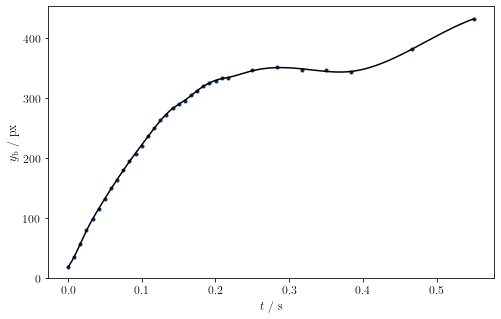

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(t, yb, '.')
ax.plot(tp, ybott(tp), color='k', ls='solid')
ax.set(
    xlabel=r'$t\ /\ \mathrm{s}$',
    ylabel=r'$y_\text{b}\ /\ \mathrm{px}$',
    ylim=(0, None)
);

There is a 'plateau' between 0.2 and 0.4 seconds

- `tlm`: Time of local maximum at that plateau

In [15]:
tlm = opt.brentq(ybott.derivative(1), a=.25, b=.325)
ylm = ybott(tlm)
tlm, ylm

(0.28813440576385835, array(350.7977035))

## Helper Functions

### `bands()`

In [16]:
def bands(pol):
    return np.linspace(pol[:, 1].max(), pol[:, 1].min(), NBANDS + 1, endpoint=True)

### `areas()`

1. Check each pixel location, if it lies inside, outside or on the edge of the reference polygon. For each y-band Count the number of pixels in that band.
2. For every of the direct contact polygons, check whether or not each pixel location lies inside the polygon.
3. For every vertical band count the pixels which of the pixels lying inside each polygon also have $y$-coordinates that belong to the band.

***Returns:*** Count of pixels in each y-band:
`'ref'`: inside the reference polygon, `'direct'`: inside the direct contact polygons  
Each pixel location corresponds to an area of one square pixel.

In [17]:
def areas(ref, directs) -> dict:
    dcont_area = np.zeros(NBANDS)
    ref_area = np.nan * np.zeros(NBANDS)
    rk = twodpg.points_in_polygon(iidx, ref) > 0
    dks = [twodpg.points_in_polygon(iidx, dpol) > 0 for dpol in directs]
    ybands = bands(ref)
    for i in range(NBANDS - 1):
        lower, upper = ybands[i], ybands[i + 1]
        if lower < YSURF:
            break
        if upper < YSURF:
            upper = YSURF
        iyband = np.logical_and(iidx[:, 1] <= lower, iidx[:, 1] > upper)
        ref_area[i] = np.count_nonzero(np.logical_and(iyband, rk))
        for dk in dks:
            dcont_area[i] += np.count_nonzero(np.logical_and(iyband, dk))
    return {'ref': ref_area, 'direct': dcont_area}

### `show()`

In [18]:
def show(fnum, rpol=None, rcent=None, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.imshow(seq[fnum], zorder=0)
    if rpol is not None:
        ax.add_artist(plt.Polygon(
            rpol, closed=False,
            fill=False, ec=pltt[2], lw=2, zorder=1
        ))
    if rcent is not None:
        ax.plot(*rcent, 'x', color=pltt[2], ms=8)
    opt = {}
    opt['xlim'] = (rcent[0] - 300, rcent[0] + 300)
    opt['ylim'] = (rcent[1] + 300, rcent[1] - 300)
    if xlim is not None:
        opt['xlim'] = xlim
    if ylim is not None:
        opt['ylim'] = ylim
    ax.set(**opt)
    fig.tight_layout()
    return fig, ax

### `show_markup()`

Make a comparison plot, left showing a 'blank' part of a video frame, right that same frame with added direct contact polygons
and sample outline.

In [19]:
def show_markup(fnum, ybands=False):
    ref, = pols[fnum,'ref']
    centr = twodpg.centroid(ref)
    directs = list(pols[fnum, 'direct'])
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
    ax1.imshow(seq[fnum])
    show(fnum, rpol=ref, rcent=centr, ax=ax2)
    ax2.set(ylim=(500, 0))
    ax2.hlines(YSURF, *ax2.get_xlim(), color='white', lw=.5, ls='dashed', zorder=.5)
    for direct in directs:
        ax2.add_artist(plt.Polygon(direct, closed=True, color=pltt[5], lw=.5))
    fig.set_size_inches(9, 4)
    fig.subplots_adjust(top=.95, bottom=.1, wspace=0)
    if ybands:
        ybands = bands(ref)
        ax2.hlines(ybands, *ax2.get_xlim(), color='white', ls='dotted', lw=.5, zorder=.6)
    return fig, (ax1, ax2)

## Video Analysis

### Side by Side Plots to Check Markup

Frame([[[149, 146, 141],
        [148, 145, 140],
        [148, 145, 140],
        ...,
        [147, 146, 142],
        [147, 146, 144],
        [145, 144, 142]],

       [[147, 144, 139],
        [147, 144, 139],
        [148, 145, 140],
        ...,
        [149, 148, 144],
        [148, 147, 143],
        [146, 145, 141]],

       [[147, 143, 140],
        [148, 144, 141],
        [148, 145, 140],
        ...,
        [153, 150, 145],
        [149, 148, 143],
        [149, 148, 143]],

       ...,

       [[133, 134, 139],
        [133, 134, 139],
        [133, 134, 139],
        ...,
        [134, 137, 142],
        [135, 138, 143],
        [134, 137, 142]],

       [[134, 135, 140],
        [133, 134, 139],
        [133, 134, 139],
        ...,
        [132, 135, 140],
        [132, 135, 140],
        [132, 135, 140]],

       [[134, 135, 140],
        [133, 134, 139],
        [133, 134, 139],
        ...,
        [132, 135, 140],
        [132, 135, 140],
        [132, 135, 140]]], dtype=uint8)
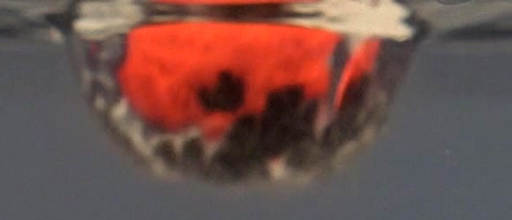

In [20]:
seq[15][:250, 200:780]

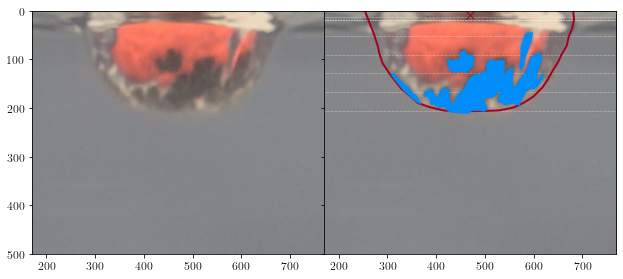

In [21]:
fig, (ax1, ax2) = show_markup(15, True)

### Collect Results for All Frames

In [22]:
area = {
    fnum: areas(pols[fnum, 'ref'][0], pols[fnum, 'direct'])
    for fnum in pols.frames
}

In [23]:
area[10]

{'ref': array([ 7963., 11843., 12344.,    nan,    nan,    nan,    nan,    nan,
           nan,    nan]),
 'direct': array([1615.,  419.,    7.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.])}

In [24]:
d_areas = np.nan * np.zeros((len(pols.frames[:-1]), NBANDS))
ref_areas = np.nan * np.zeros((len(pols.frames[:-1]), NBANDS))
for i in range(NBANDS):
    d_areas[:, i] = np.array([area[fnum]['direct'][i] for fnum in pols.frames[:-1]])
    ref_areas[:, i] = np.array([area[fnum]['ref'][i] for fnum in pols.frames[:-1]])

In [25]:
rel_areas = np.empty_like(ref_areas)
idx = ~np.isclose(ref_areas, 0)
rel_areas[idx] = d_areas[idx] / ref_areas[idx]
rel_areas[rel_areas > 1.] = 1

In [26]:
yb_centers = bands(pols[10, 'ref'][0])[:-1]
yb_centers = IMRES * (yb_centers[0] - yb_centers)
Δymm = (yb_centers[-1] - yb_centers[0]) / (len(yb_centers) - 1)
Δymm

3.105479581999999

In [27]:
yb_centers += .5 * Δymm
yb_centers

array([ 1.55273979,  4.65821937,  7.76369895, 10.86917854, 13.97465812,
       17.0801377 , 20.18561728, 23.29109687, 26.39657645, 29.50205603])

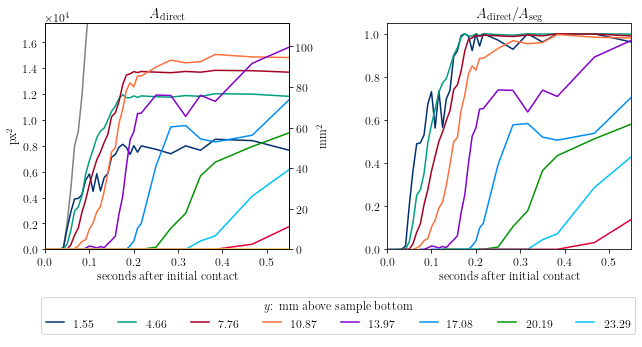

In [28]:
fig, axs = plt.subplot_mosaic('AB\nAB\nAB\nCC', figsize=(9, 5))
ax1, ax2, ax3 = axs['A'], axs['B'], axs['C']

ax1.plot(t, d_areas.sum(axis=1), color='gray')
ax1.set(
    xlabel='seconds after initial contact',
    ylabel=r'$\mathrm{px^2}$',
    xlim=t[[0, -1]],
    ylim=(0, 1.75e4),
    title=r'$A_\text{direct}$'
)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-1, 3))
ax1a = ax1.twinx()
ax1a.set(
    ylim=(0, 1.75e4 * IMRES ** 2),
    ylabel=r'$\mathrm{mm^2}$'
)
ax2.set(
    xlabel=r'seconds after initial contact',
    title=r'$A_\text{direct} / A_\text{seg}$',
    xlim=t[[0, -1]],
    ylim=(0, 1.05)
)
for i, ybc in enumerate(yb_centers):
    ax1.plot(t, d_areas[:, i])
    ax2.plot(t, rel_areas[:, i])
    if i < 8:
        ax3.plot([], [], label=f'{ybc:.2f}')
ax3.legend(
    loc='lower center', ncol=8, handlelength=1.5,
    title=r'$y\text{: mm above sample bottom}$')
for v in ax3.spines.values():
    v.set_visible(False)
ax3.set(xticks=[], yticks=[])
fig.subplots_adjust(left=.075, right=.98, bottom=.0, wspace=.4, hspace=1)

### Y-Dependency of First Contacts

Tracking some reference point on the sample, for example it's bottom, $y_\text{b}$, allows to determine
the time of first contact of each $y$-band, which can be used to say something about  film lifetime.

If $y_i$ is the vertical coordinate of the center of the $i$-th band above the sample bottom, it relates to
$y_\text{b}$ byt the offset

$$
y_i(t) = y_\text{b}(t) - \bigl(1/2 + i\bigr)\,\frac{y_\text{b}-y_\text{t}}{N_\text{bands}}
= y_\text{b}(t) - \bigl(1/2 + i\bigr)\,\Delta y
\quad,\quad
i = 0, 1, \dots, 9
\quad.
$$

$\Delta y$ is the sample's height and does not depend on the (current) sample position.

Since the sample bottom $y_\text{b}(t)$ is not given as formula, inversion of the dependency must be done numerically.

In [29]:
tsubs = .418

In [30]:
t[-6]

0.2836166666666667

In [31]:
yslope = (ybott(tsubs) - ybott(t[-6])) / (tsubs - t[-6])

def ybtm(time):
    time, isarr = np.asarray(time), True
    if time.ndim < 1:
        time, isarr = np.array([time]), False
    ret = np.empty_like(time)
    idx = np.logical_and(time > t[-6], time < tsubs)
    if np.any(idx):
        ret[idx] = ybott(t[-6]) + (time[idx] - t[-6]) * yslope
    idx = ~idx
    if np.any(idx):
        ret[idx] = ybott(time[idx])
    return ret if isarr else ret[0]

In [32]:
ybott(t[-6])

array(350.73607352)

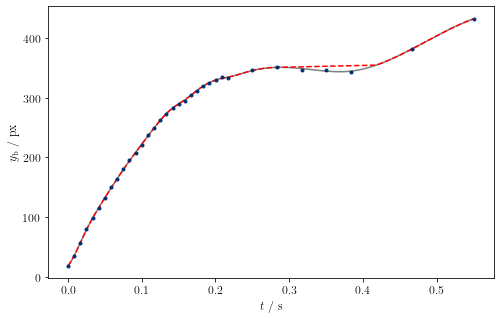

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(t, yb, '.', zorder=1)
ax.plot(tp, ybott(tp), color='gray', ls='solid', zorder=0)
ax.plot(tp, ybtm(tp), color='red', ls='dashed', zorder=0.5)
ax.set(
    xlabel=r'$t\ /\ \mathrm{s}$',
    ylabel=r'$y_\text{b}\ /\ \mathrm{px}$'
);

In [34]:
ybands = np.array([bands(pols[frame, 'ref'][0]) for frame in pols.frames])

In [35]:
Δy = (ybands[0, 0] - ybands[0, -1]) / NBANDS
Δy

38.9

In [36]:
350 / Δy

8.997429305912597

In [37]:
tf = []
for i in range(NBANDS):
    def func(x):
        return ybtm(x) - YSURF - (.5 + i) * Δy
    fa, fb = func(0), func(.6)
    if fa * fb > 0:
        print(f"skipping {i}")
        continue
    tf.append(opt.brentq(func, a=0., b=.6))
tf = np.asarray(tf)
tf

array([0.00950238, 0.02430661, 0.04184416, 0.06166185, 0.08320849,
       0.10659432, 0.13227335, 0.17344771, 0.26943686, 0.47744155])

In [38]:
rref_areas = ref_areas.copy()
rref_areas[np.isnan(ref_areas)] = 0.

In [39]:
d_areas.sum(axis=1) / rref_areas.sum(axis=1)

/tmp/ipykernel_23885/2558391056.py:1: RuntimeWarning: invalid value encountered in true_divide
  d_areas.sum(axis=1) / rref_areas.sum(axis=1)


array([       nan, 0.        , 0.        , 0.        , 0.        ,
       0.00488856, 0.06348367, 0.12084018, 0.18033156, 0.17790979,
       0.20880704, 0.25556309, 0.28724047, 0.2736467 , 0.30452053,
       0.28957977, 0.31256254, 0.33374065, 0.37788609, 0.38606593,
       0.42722903, 0.4573737 , 0.48316178, 0.49738191, 0.50614233,
       0.52091689, 0.53208475, 0.56645395, 0.5972863 , 0.60618145,
       0.63843509, 0.6676267 , 0.68439241, 0.7441744 ])

In [40]:
tf

array([0.00950238, 0.02430661, 0.04184416, 0.06166185, 0.08320849,
       0.10659432, 0.13227335, 0.17344771, 0.26943686, 0.47744155])

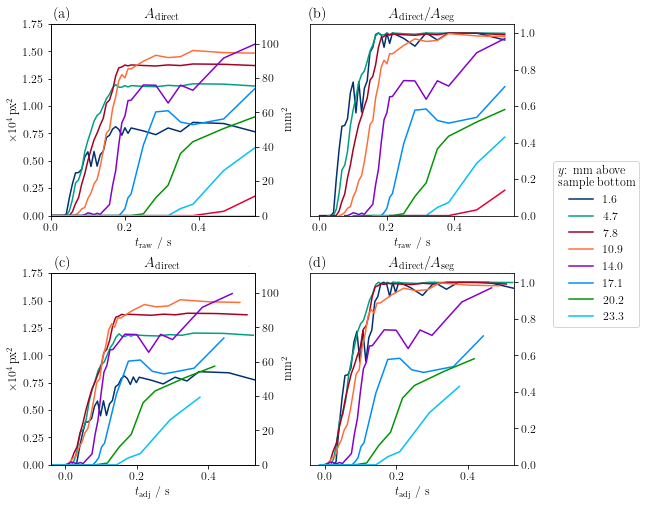

In [41]:
fig, axs = plt.subplot_mosaic(
    '''
    AABBL
    CCDDL
    ''', figsize=(9, 7))
ax1, ax2, ax3, ax4 = axs['A'], axs['B'], axs['C'], axs['D']
legax = axs['L']

ax1.set(
    xlabel=r'$t_\text{raw}\ /\ \mathrm{s}$',
    ylabel=r'$\times10^4\,\mathrm{px^2}$',
    xlim=t[[0, -1]],
    ylim=(0, 1.75),
    title=r'(a) \hspace*{2.4cm}$A_\text{direct}$\hspace*{2.4cm}{\tiny .}'
)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-1, 3))
ax1a = ax1.twinx()
ax1a.set(
    ylim=(0, 1.75e4 * IMRES ** 2),
    ylabel=r'$\mathrm{mm^2}$'
)
ax2.set(
    xlabel=r'$t_\text{raw}\ /\ \mathrm{s}$',
    title=r'(b) \hspace*{2cm}$A_\text{direct} / A_\text{seg}$\hspace*{2cm}{\tiny .}',
    ylim=(0, 1.05)
)
ax2.yaxis.set_ticks_position('right')
ax3.set(
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
    ylabel=r'$\times10^4\,\mathrm{px^2}$',
    title=r'(c) \hspace*{2.4cm}$A_\text{direct}$\hspace*{2.4cm}{\tiny .}',
    xlim=(-.04, .53),
    ylim=(0, 1.75)
)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-1, 3))
ax3a = ax3.twinx()
ax3a.set(
    ylim=(0, 1.75e4 * IMRES ** 2),
    ylabel=r'$\mathrm{mm^2}$'
)
ax4.set(
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
    title=r'(d) \hspace*{2cm}$A_\text{direct} / A_\text{seg}$\hspace*{2cm}{\tiny .}',
    xlim=(-.04, .53), ylim=(0, 1.05)
)
ax4.yaxis.set_ticks_position('right')
for v in legax.spines.values():
    v.set_visible(False)
legax.set(xticks=[], yticks=[])

for i, ybc in enumerate(yb_centers):
    ax1.plot(t, d_areas[:, i] / 1e4)
    ax2.plot(t, rel_areas[:, i])
    if i < 8:
        ax3.plot(t - tf[i], d_areas[:, i] / 1e4)
        ax4.plot(t - tf[i], rel_areas[:, i])
        legax.plot([], [], label=f'{ybc:.1f}')
legax.legend(
    loc='center left', title=r'\noindent $y$: mm above\\ sample bottom',
    bbox_to_anchor=(-0.3, 0.5)
)
fig.subplots_adjust(
    top=.95, bottom=.075, left=.075, right=.99,
    hspace=.3, wspace=.75
)
fig.canvas.draw()
ax1.yaxis.set_offset_position('left')

### Fit Time Dependency

In [42]:
arels = np.concatenate([rel_areas[:, i] for i in (0, 1, 2)])
idx = ~np.isnan(arels)
arels = arels[idx]
# arels

In [43]:
ts = np.concatenate([t - tf[i] for i in (0, 1, 2)])[idx]
# ts

$$
f(t) = 1 - e^{-{(a\,t)}^2}
$$

In [44]:
def func(x, a, x0):
    x, reta = np.asarray(x), True
    if x.ndim < 1:
        x, reta = np.asarray([x]), False
    ret = np.empty_like(x)
    idx = x < x0
    ret[idx] = 0.
    idx = ~idx
    ret[idx] =  1. - np.exp(-((a * (x[idx] - x0)) ** 2))
    return ret if reta else ret[0]

In [45]:
res = opt.curve_fit(func, ts, arels, bounds=([1, -1e-10], [100, 1e-10]),
                     maxfev=1000000)
res

(array([ 1.12756512e+01, -9.99999278e-11]),
 array([[1.73110129e-01, 1.08566319e-03],
        [1.08566319e-03, 8.01569751e-06]]))

In [46]:
racrit = 1 - np.exp(-1)
racrit

0.6321205588285577

In [47]:
tcrit = opt.brentq(lambda x: func(x, res[0][0], 0) - racrit, 0, 1)
tcrit

0.08868667418092455

In [48]:
1 / res[0][0]

0.08868667418087003

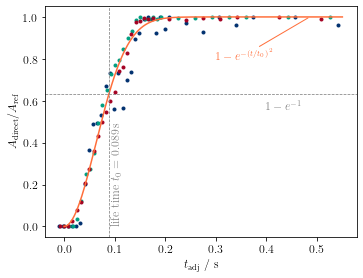

In [49]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(t - tf[i], rel_areas[:, i], '.')
line, = ax.plot(tp, func(tp, res[0][0], 0))
clr = line.get_color()
ax.axhline(y=racrit, ls='dashed', lw=.75, color='gray')
ax.text(x=.4, y=.95 * racrit, s=r'$1-e^{-1}$', ha='left', va='top', color='gray')
ax.axvline(x=tcrit, ls='dashed', lw=.75, color='gray')
ax.text(x=1.05 * tcrit, y=0., s=r'$\text{life time }t_0=%.3f\,\mathrm{s}$' % tcrit,
        rotation=90, va='bottom', ha='left', color='gray')
ax.annotate(
    text=r'$1-e^{-{(t/t_{0})}^2}$', xy=(.486, func(.486, res[0][0], 0)),
    xytext=(.3, .8), color=clr, ha='left',
    arrowprops=dict(arrowstyle='-', color=clr)
)
ax.set(
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
    ylabel=r'$A_\text{direct}/A_\text{ref}$'
)
fig.set(size_inches=(5, 4))
fig.subplots_adjust(top=.95, right=.99, bottom=.15)

In [50]:
res = [res]

In [51]:
res

[(array([ 1.12756512e+01, -9.99999278e-11]),
  array([[1.73110129e-01, 1.08566319e-03],
         [1.08566319e-03, 8.01569751e-06]]))]

In [52]:
for i in range(3, 6):
    arels = rel_areas[:, i]
    idx = ~np.isnan(arels)
    arels = arels[idx]
    res.append(
        opt.curve_fit(func, t[idx] - tf[i], arels, p0=[1., 0.],
                      bounds=([.1, -1e-1], [100, 1]))
    )

In [53]:
res

[(array([ 1.12756512e+01, -9.99999278e-11]),
  array([[1.73110129e-01, 1.08566319e-03],
         [1.08566319e-03, 8.01569751e-06]])),
 (array([11.05833511,  0.01442502]),
  array([[1.58513827e-01, 1.01582964e-03],
         [1.01582964e-03, 7.58333847e-06]])),
 (array([6.91158013, 0.00782185]),
  array([[1.34424496e+00, 1.84839677e-02],
         [1.84839677e-02, 2.96380099e-04]])),
 (array([ 2.91183345, -0.03010031]),
  array([[0.17256676, 0.01144219],
         [0.01144219, 0.00095818]]))]

In [54]:
racrit = 0.9

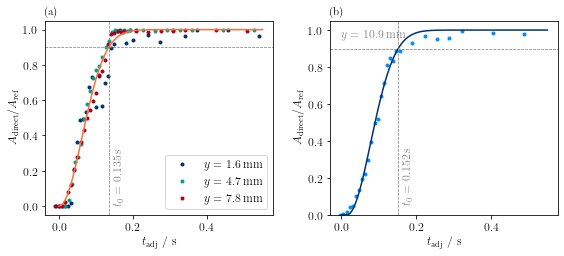

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

for i in range(3):
    ax1.plot(t - tf[i], rel_areas[:, i], '.', label=r'$y=%.1f\,\mathrm{mm}$' % yb_centers[i])
tcrit = opt.brentq(lambda x: func(x, *res[0][0]) - racrit, 0, 2.5)
line, = ax1.plot(tp, func(tp, res[0][0][0], 0))
clr = line.get_color()
ax1.axhline(y=racrit, ls='dashed', lw=.75, color='gray')
ax1.axvline(x=tcrit, ls='dashed', lw=.75, color='gray')
ax1.text(x=tcrit + .01, y=0., s=r'$t_0=%.3f\,\mathrm{s}$' % tcrit,
        rotation=90, va='bottom', ha='left', color='gray')
ax1.set(
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
    ylabel=r'$A_\text{direct}/A_\text{ref}$'
)
ax1.legend(loc='lower right')
ax1.set_title(r'(a)', loc='left', fontsize=11)
arels = rel_areas[:, 3]
idx = ~np.isnan(arels)
arels = arels[idx]
tcrit = opt.brentq(lambda x: func(x, *res[1][0]) - racrit, 0, 2.5)
ax2.plot(t[idx] - tf[3], arels, '.', color=pltt[5])
line, = ax2.plot(tp, func(tp, *res[1][0]), color=pltt[0])
clr = line.get_color()
ax2.text(0, 1, r'$y=%.1f\,\text{mm}$' % yb_centers[3],
        ha='left', va='top', color='gray')
ax2.axhline(y=racrit, ls='dashed', lw=.75, color='gray')
ax2.axvline(x=tcrit, ls='dashed', lw=.75, color='gray')
ax2.text(x=tcrit + .01, y=0.05, s=r'$t_0=%.3f\,\mathrm{s}$' % tcrit,
        rotation=90, va='bottom', ha='left', color='gray')
ax2.set(
    xlabel=r'$t_\text{adj}\ /\ \mathrm{s}$',
    ylabel=r'$A_\text{direct}/A_\text{ref}$',
    ylim=(0, 1.05)
)
ax2.set_title(r'(b)', loc='left', fontsize=11)
fig.set(size_inches=(8, 3.5))
fig.subplots_adjust(top=.92, right=.99, bottom=.15, left=.1, wspace=.25)

## Export to `asdf`

In [56]:
def export():
    p = Path('../data/run2_alldata.asdf')
    af = asdf.open(p, mode='rw') if p.exists() else asdf.AsdfFile(uri=str(p))
    if 'raw' not in af.keys():
        af['raw'] = {}
    afraw = af['raw']
    if 'polygons' not in afraw.keys():
        afraw['polygons'] = {}
    afpols = afraw['polygons']
    for frame in pols.frames:
        if frame not in afpols.keys():
            afpols[frame] = {}
        afpols[frame]['ref'] = pols[frame, 'ref'][0]
        try:
            afpols[frame]['film'] = pols[frame, 'film'][0]
        except KeyError:
            pass
        try:
            afpols[frame]['direct'] = pols[frame, 'direct']
        except KeyError:
            pass
    afraw['FRATE'] = FRATE
    afraw['IMRES'] = IMRES
    af['key_frames'] = {'FSTART': FSTART, 'FREF': FREF}
    af['key_frames']['desc'] = \
    '- `FSTART`: First contact of sample with water.\n' \
    '- `FREF`: Reference frame from which the sample outline was created.'
    af['frames_analyzed'] = pols.frames[:-1]
    af['time'] = {
        't': t,
        'tf': tf
    }
    if 'area' not in af.keys():
        af['area'] = {}
    ar = af['area']
    ar['yb_centers'] = yb_centers
    ythr = yb_centers[:4]
    ar['t'] = t
    ar['direct'] = d_areas
    ar['ref'] = ref_areas
    ar['rel'] = rel_areas
    ar['fit'] = np.asarray([r[0] for r in res])
    ar['ythr'] = ythr
    af.info()
    af.write_to(af.uri, all_array_compression='zlib')
    af.close()